## Multi Agents

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

In [2]:
llm = ChatOpenAI(model = 'gpt-4o-mini')
llm.invoke('hi')

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 8, 'total_tokens': 17, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-Bl69mcBpBBUYdIBtcFVmHysD2lQmi', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--7421b5b2-773c-42de-a75b-d26a91297c80-0', usage_metadata={'input_tokens': 8, 'output_tokens': 9, 'total_tokens': 17, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

### Single Agents vs Multi Agents

In [3]:
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent

In [ ]:
# class AgentState(TypedDict):
#     messages: Annotated[Sequence[BaseMessage], add_messages]
#     Name:str
#     age:int
#     DOB:int

In [4]:
def add_number(state):
    result = state['num1'] + state['num2']
    print(f"Addition is {result}")
    return Command(goto='multiply', update={'sum':result})

In [6]:
add_number({'num1':10,'num2':20})

Addition is 30


Command(update={'sum': 30}, goto='multiply')

### Creating Network Dummy Agent

In [7]:
from langchain_core.tools import tool

In [8]:
@tool
def transfer_to_multiplication_expert():
    """Ask multiplication agent for help"""
    return

In [9]:
@tool
def transfer_to_addition_expert():
    """Ask addition agent for help"""
    return

In [10]:
llm_with_tool=llm.bind_tools([transfer_to_multiplication_expert])

In [17]:
response=llm_with_tool.invoke("what is 2 multiply 2?")
print(response.content)
print(response.tool_calls)


[{'name': 'transfer_to_multiplication_expert', 'args': {}, 'id': 'call_nRgLC0KdjXPhoOdSezTBLvvL', 'type': 'tool_call'}]


In [11]:
from typing_extensions import Literal
from langgraph.graph import MessagesState,StateGraph, START,END

In [ ]:
def additional_expert(state:MessagesState)-> Command[Literal["multiplication_expert", "__end__"]]:
    
    system_prompt = (
        "You are an addition expert, you can ask the multiplication expert for help with multiplication."
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    
    ai_msg = llm.bind_tools([transfer_to_multiplication_expert]).invoke(messages)
    
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        
        return Command(
            goto="multiplication_expert", update={"messages": [ai_msg, tool_msg]}
        )
    return {"messages": [ai_msg]}

In [24]:
##Agent2
def multiplication_expert(state:MessagesState)-> Command[Literal["additional_expert", "__end__"]]:
    
    system_prompt = (
        "You are a multiplication expert, you can ask an addition expert for help with addition. "
        "Always do your portion of calculation before the handoff."
    )
    
    messages = [{"role": "system", "content": system_prompt}] + state["messages"]
    
    ai_msg = llm.bind_tools([transfer_to_addition_expert]).invoke(messages)
    
    if len(ai_msg.tool_calls) > 0:
        tool_call_id = ai_msg.tool_calls[-1]["id"]
        tool_msg = {
            "role": "tool",
            "content": "Successfully transferred",
            "tool_call_id": tool_call_id,
        }
        return Command(goto="additional_expert", update={"messages": [ai_msg, tool_msg]})
    return {"messages": [ai_msg]}

In [26]:
graph=StateGraph(MessagesState)
graph.add_node("additional_expert",additional_expert)
graph.add_node("multiplication_expert",multiplication_expert)
graph.add_edge(START, "additional_expert")

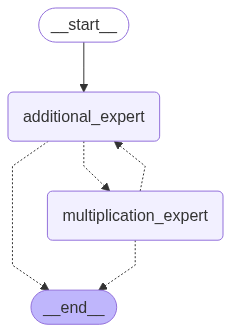

In [28]:
app = graph.compile()
app

In [29]:
app.invoke({'messages':['What is (2+2)*3']})

{'messages': [HumanMessage(content='What is (2+2)*3', additional_kwargs={}, response_metadata={}, id='ce8b1e8e-3e58-4411-a7ff-5d1c7063d64a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_VWXfzEMKHmuoV5TeUsgDeHbz', 'function': {'arguments': '{}', 'name': 'transfer_to_multiplication_expert'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 78, 'total_tokens': 93, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-Bl79CEuu42l3Nhgdb8S7ASFu4YyTC', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--50adef9c-296e-4610-be3a-6d812801d4b4-0', tool_calls=[{'name': 'transfer_to_multiplication_expert', 'args': {}, 'id': 'call

## With RealtimeTool

In [31]:
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_experimental.utilities import PythonREPL

In [41]:
search_tool=DuckDuckGoSearchRun()

In [32]:
repl=PythonREPL()
code = """
x = 5
y = x * 2
print(y)
"""
repl.run(code)

Python REPL can execute arbitrary code. Use with caution.


'10\n'

In [33]:
from typing import Annotated

In [40]:
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )
    

<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
<>:13: SyntaxWarning: invalid escape sequence '\`'
C:\Users\ashut\AppData\Local\Temp\ipykernel_33904\1459227625.py:13: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
C:\Users\ashut\AppData\Local\Temp\ipykernel_33904\1459227625.py:13: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [35]:
python_repl_tool

StructuredTool(name='python_repl_tool', description='Use this to execute python code. If you want to see the output of a value,\n    you should print it out with `print(...)`. This is visible to the user.', args_schema=<class 'langchain_core.utils.pydantic.python_repl_tool'>, func=<function python_repl_tool at 0x0000015DDB9EAAC0>)

In [36]:
print(python_repl_tool.invoke(code))

Successfully executed:
\`\`\`python

x = 5
y = x * 2
print(y)

\`\`\`
Stdout: 10


If you have completed all tasks, respond with FINAL ANSWER.


In [42]:
def make_system_prompt(instruction:str)->str:
    return  (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{instruction}"
    )

In [43]:
make_system_prompt("You can only do research. You are working with a chart generator colleague.")

"You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.\nYou can only do research. You are working with a chart generator colleague."

In [44]:
from langchain_core.messages import BaseMessage

In [45]:
def get_next_node(last_message:BaseMessage, goto:str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [49]:
from langchain_core.messages import HumanMessage

In [50]:
#agent1
from matplotlib.pyplot import get


def research_node(state:MessagesState)->Command[Literal["chart_generator", END]]:
    research_agent=create_react_agent(
        llm,
        tools=[search_tool],
        prompt=make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    ),
        )
    
    message=research_agent.invoke(state)
    result = message['messages'][-1]
    goto=get_next_node(result, "chart_generator")
    result['messages'][-1] = HumanMessage(content=result['messages'][-1].content, name='researcher')
    return Command(update={"messages": result["messages"]},goto=goto)

In [51]:
#agent2
def chart_node(state:MessagesState)-> Command[Literal["researcher", END]]:
    chart_agent=create_react_agent(
        llm,
        tools=[python_repl_tool],
        prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
        )
    message=chart_agent.invoke(state)
    result = message['messages'][-1]
    goto='researcher'
    goto = get_next_node(result, goto)
    result['messages'][-1] = HumanMessage(content=result['messages'][-1].content, name='chart_generator')
    
    return Command(update={"messages": result["messages"]},goto=goto)

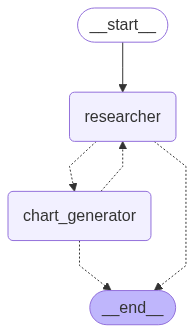

In [52]:
workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
app = workflow.compile()
app